# Token Replay Prototyping

In [250]:
from collections import defaultdict
%reload_ext autoreload
%autoreload 2

import pm4py
import random
from practical.ProcessMining.group1.shared.visualizer import Visualizer as vizard
from practical.ProcessMining.group1.shared.utils import event_log_to_dataframe, read_txt_test_logs

logs = read_txt_test_logs("../shared/example_files/simple_event_logs.txt")

## Visualization Test

In [278]:
def mock_missing_remaining_tokens(places):
    tokens = {"missing": defaultdict(), "remaining": defaultdict()}
    middle_places = [p for p in places if p != "start" and p != "end"]
    for place in random.sample(middle_places, len(middle_places)//2):
        tokens["missing"][place] = random.randint(1, 10)
    for place in random.sample(middle_places, len(middle_places)//2):
        tokens["remaining"][place] = random.randint(1, 10)
    return tokens

In [277]:
log = logs['L2']
log = event_log_to_dataframe(log)
log = pm4py.format_dataframe(log, case_id='case_id', activity_key='activity', timestamp_key='timestamp')

In [233]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)

In [234]:
net

places: [ ({'b'}, {'d', 'e'}), ({'c'}, {'d', 'e'}), ({'e'}, {'f'}), ({'f', 'a'}, {'b'}), ({'f', 'a'}, {'c'}), end, start ]
transitions: [ (a, 'a'), (b, 'b'), (c, 'c'), (d, 'd'), (e, 'e'), (f, 'f') ]
arcs: [ (a, 'a')->({'f', 'a'}, {'b'}), (a, 'a')->({'f', 'a'}, {'c'}), (b, 'b')->({'b'}, {'d', 'e'}), (c, 'c')->({'c'}, {'d', 'e'}), (d, 'd')->end, (e, 'e')->({'e'}, {'f'}), (f, 'f')->({'f', 'a'}, {'b'}), (f, 'f')->({'f', 'a'}, {'c'}), ({'b'}, {'d', 'e'})->(d, 'd'), ({'b'}, {'d', 'e'})->(e, 'e'), ({'c'}, {'d', 'e'})->(d, 'd'), ({'c'}, {'d', 'e'})->(e, 'e'), ({'e'}, {'f'})->(f, 'f'), ({'f', 'a'}, {'b'})->(b, 'b'), ({'f', 'a'}, {'c'})->(c, 'c'), start->(a, 'a') ]

In [235]:
initial_marking

['start:1']

In [236]:
final_marking

['end:1']

In [237]:
places = net.places
transitions = net.transitions
arcs = net.arcs

In [238]:
places

{({'b'}, {'d', 'e'}),
 ({'c'}, {'d', 'e'}),
 ({'e'}, {'f'}),
 ({'f', 'a'}, {'b'}),
 ({'f', 'a'}, {'c'}),
 end,
 start}

In [239]:
transitions

{(a, 'a'), (b, 'b'), (c, 'c'), (d, 'd'), (e, 'e'), (f, 'f')}

In [240]:
arcs

{(a, 'a')->({'f', 'a'}, {'b'}),
 (a, 'a')->({'f', 'a'}, {'c'}),
 (b, 'b')->({'b'}, {'d', 'e'}),
 (c, 'c')->({'c'}, {'d', 'e'}),
 (d, 'd')->end,
 (e, 'e')->({'e'}, {'f'}),
 (f, 'f')->({'f', 'a'}, {'b'}),
 (f, 'f')->({'f', 'a'}, {'c'}),
 ({'b'}, {'d', 'e'})->(d, 'd'),
 ({'b'}, {'d', 'e'})->(e, 'e'),
 ({'c'}, {'d', 'e'})->(d, 'd'),
 ({'c'}, {'d', 'e'})->(e, 'e'),
 ({'e'}, {'f'})->(f, 'f'),
 ({'f', 'a'}, {'b'})->(b, 'b'),
 ({'f', 'a'}, {'c'})->(c, 'c'),
 start->(a, 'a')}

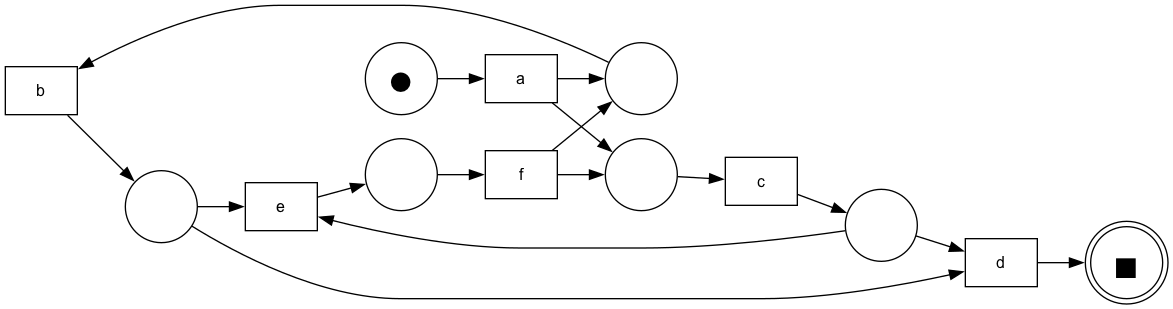

In [241]:
graph = vizard(net, initial_marking, final_marking, {}).get_petri_net()
vizard.display(graph)

In [265]:
missing_remaining_tokens = mock_missing_remaining_tokens(places)
missing_remaining_tokens

{'missing': defaultdict(None,
             {({'f', 'a'}, {'b'}): 7,
              ({'f', 'a'}, {'c'}): 7,
              ({'b'}, {'d', 'e'}): 7}),
 'remaining': defaultdict(None,
             {end: 2, ({'e'}, {'f'}): 5, ({'f', 'a'}, {'b'}): 10})}

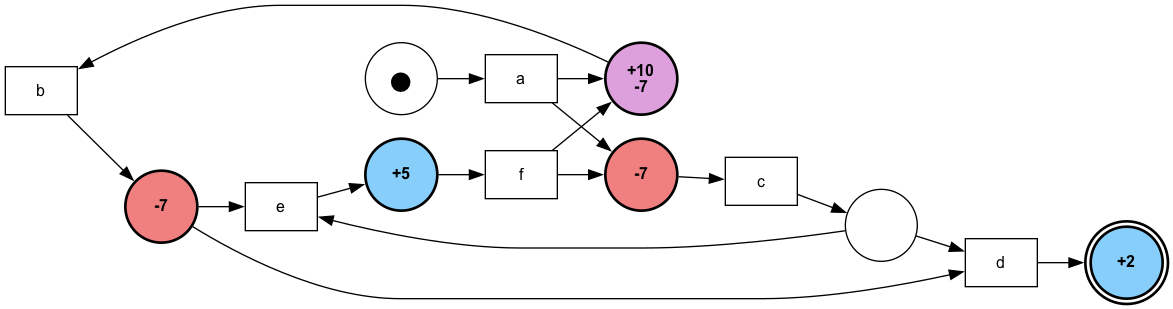

In [271]:
graph_fitness = vizard(net, initial_marking, final_marking, missing_remaining_tokens).get_petri_net()
vizard.display(graph_fitness)

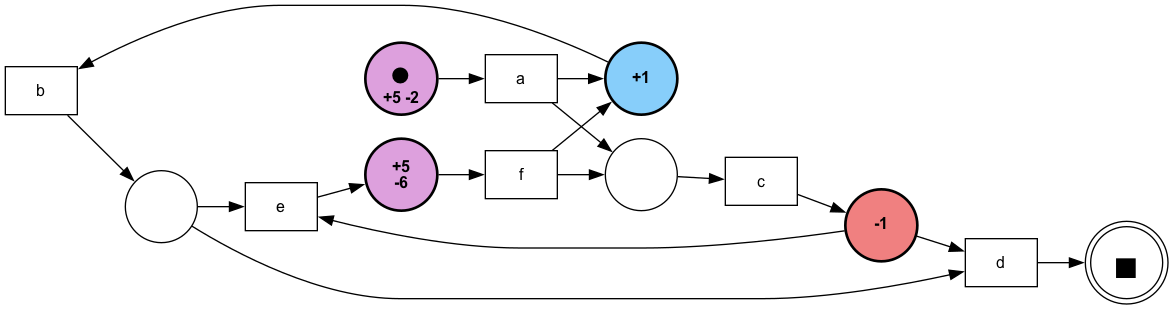

In [272]:
vizard.display(vizard(net, initial_marking, final_marking, mock_missing_remaining_tokens(places)).get_petri_net())

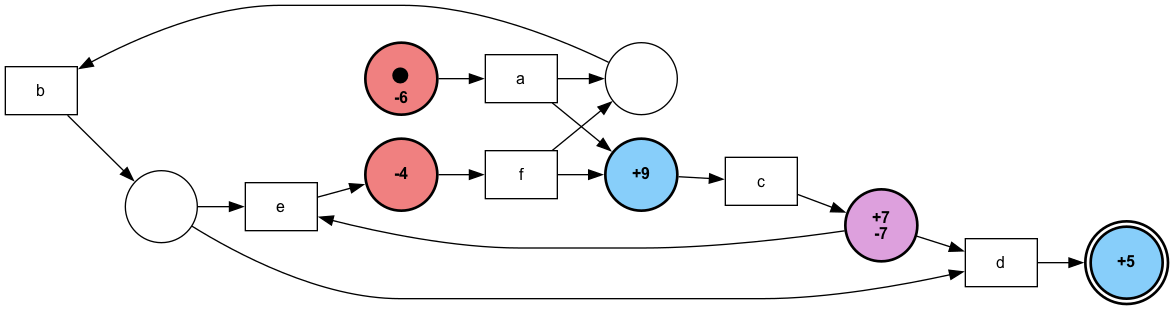

In [274]:
vizard.display(vizard(net, initial_marking, final_marking, mock_missing_remaining_tokens(places)).get_petri_net())

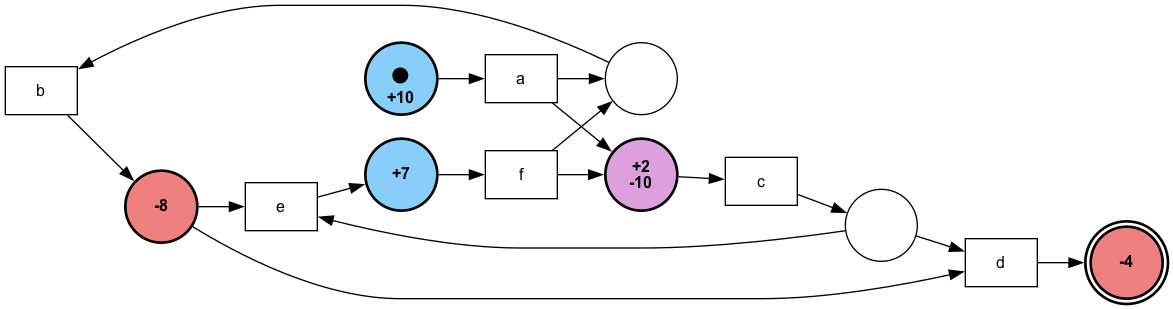

In [276]:
vizard.display(vizard(net, initial_marking, final_marking, mock_missing_remaining_tokens(places)).get_petri_net())